In [1]:
import pandas as pd
import numpy as np

file_readm = "/home/idies/workspace/Storage/ehan20/persistent/as.180.369/contrib/ElvisHan2022/Copy of FY 2019 IPPS Proposed Rule Readmissions Supplemental Data File.xlsx"
sheet_name = "NPRM FY 2019"

# --- Step 1 : Read first few rows (no header) to detect where "Hospital CCN" appears ---
preview = pd.read_excel(file_readm, sheet_name=sheet_name, header=None, nrows=10)

header_row = None
for i, row in preview.iterrows():
    if row.astype(str).str.contains("Hospital CCN", case=False, na=False).any():
        header_row = i
        break

if header_row is None:
    header_row = 0  # fallback if pattern not found

print(f"Detected header row = {header_row}")

# --- Step 2 : Read the sheet again using the detected header row ---
df = pd.read_excel(file_readm, sheet_name=sheet_name, header=header_row)

# --- Step 3 : Clean column names (strip spaces, collapse multiple spaces) ---
df.columns = (
    df.columns.astype(str)
    .str.replace("\xa0", " ", regex=False)     # remove non-breaking spaces
    .str.replace(r"\s+", " ", regex=True)      # collapse extra spaces
    .str.strip()
)

print("✅ Loaded HRRP sheet successfully!")
print("Shape:", df.shape)
print("First 10 columns:")
print(df.columns.tolist()[:10])


Detected header row = 1
✅ Loaded HRRP sheet successfully!
Shape: (3167, 35)
First 10 columns:
['Hospital CCN', 'FY 2019 Proposed Proxy Payment Adjustment Factor', 'Dual proportion', 'Peer group assignment', 'Neutrality modifier', 'Number of eligible discharges for AMI', 'ERR for AMI', 'Peer group median ERR for AMI', 'Penalty indicator for AMI', 'DRG payment ratio for AMI']


In [2]:
# ==============================================================
# STEP 4.  BUILD df_eda (EXPLORATORY DATASET)
# --------------------------------------------------------------
# We isolate the columns required for our descriptive and regression
# analyses.  Columns not in this list (e.g., documentation sheets)
# are ignored to reduce clutter.
# ==============================================================

cols_keep = [
    "Hospital CCN",
    "FY 2019 Proposed Proxy Payment Adjustment Factor",
    "Dual proportion",
    "Peer group assignment",
    "Neutrality modifier",

    # Condition-specific variables
    "Number of eligible discharges for AMI", "ERR for AMI", "Peer group median ERR for AMI", "Penalty indicator for AMI", "DRG payment ratio for AMI",
    "Number of eligible discharges for COPD", "ERR for COPD", "Peer group median ERR for COPD", "Penalty indicator for COPD", "DRG payment ratio for COPD",
    "Number of eligible discharges for HF", "ERR for HF", "Peer group median ERR for HF", "Penalty indicator for HF", "DRG payment ratio for HF",
    "Number of eligible discharges for Pneumonia", "ERR for Pneumonia", "Peer group median ERR for Pneumonia", "Penalty indicator for Pneumonia", "DRG payment ratio for Pneumonia",
    "Number of eligible discharges for CABG", "ERR for CABG", "Peer group median ERR for CABG", "Penalty indicator for CABG", "DRG payment ratio for CABG",
    "Number of eligible discharges for THA/TKA", "ERR for THA/TKA", "Peer group median ERR for THA/TKA", "Penalty indicator for THA/TKA", "DRG payment ratio for THA/TKA",
]

# Only keep columns that exist (avoids KeyErrors)
cols_present = [c for c in cols_keep if c in df.columns]
df_eda = df[cols_present].copy()

# Rename a few long variables for easier referencing later
df_eda = df_eda.rename(columns={
    "FY 2019 Proposed Proxy Payment Adjustment Factor": "A_h",  # Payment-Adjustment factor
    "Dual proportion": "DualShare",
    "Peer group assignment": "PeerGroup",
})

print("✅ Variables selected for EDA:", len(df_eda.columns))


✅ Variables selected for EDA: 35


In [3]:
# ==============================================================
# STEP 5.  CLEAN VALUES AND CREATE PENALTY FLAGS
# --------------------------------------------------------------
# 1. Replace text placeholders (e.g., "NQ") with NaN.
# 2. Coerce numeric columns.
# 3. Normalize Y/N penalty indicators.
# 4. Create binary flags:
#      • Penalized_any → 1 if A_h < 1
#      • Pen_AMI ... Pen_THA_TKA → 1 if CMS lists Y for that condition
# ==============================================================

df_eda = df_eda.replace("NQ", np.nan)

# Normalize penalty indicators and numeric variables
for c in df_eda.columns:
    if c.startswith("Penalty indicator"):
        df_eda[c] = df_eda[c].astype(str).str.upper().str.strip()
    else:
        df_eda[c] = pd.to_numeric(df_eda[c], errors="ignore")

for c in ["A_h", "DualShare", "Neutrality modifier"]:
    if c in df_eda.columns:
        df_eda[c] = pd.to_numeric(df_eda[c], errors="coerce")

# Overall penalty status
df_eda["Penalized_any"] = np.where(df_eda["A_h"] < 1, 1, 0)

# Condition-specific penalty flags
cond_map = {
    "AMI": "Penalty indicator for AMI",
    "COPD": "Penalty indicator for COPD",
    "HF": "Penalty indicator for HF",
    "Pneumonia": "Penalty indicator for Pneumonia",
    "CABG": "Penalty indicator for CABG",
    "THA_TKA": "Penalty indicator for THA/TKA",
}
for k, col in cond_map.items():
    if col in df_eda.columns:
        df_eda[f"Pen_{k}"] = df_eda[col].map({"Y": 1, "N": 0}).astype("Int64")

print("✅ Data cleaned. Preview:")
display(df_eda.head(3))


✅ Data cleaned. Preview:


/tmp/ipykernel_419/3316998736.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_eda = df_eda.replace("NQ", np.nan)
/tmp/ipykernel_419/3316998736.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_eda[c] = pd.to_numeric(df_eda[c], errors="ignore")
/tmp/ipykernel_419/3316998736.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_eda[c] = pd.to_numeric(df_eda[c], errors="ignore")
/tmp/ipykernel_419/3316998736.py:19: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric withou

,Hospital CCN,A_h,DualShare,PeerGroup,Neutrality modifier,Number of eligible discharges for AMI,ERR for AMI,Peer group median ERR for AMI,Penalty indicator for AMI,DRG payment ratio for AMI,...,Peer group median ERR for THA/TKA,Penalty indicator for THA/TKA,DRG payment ratio for THA/TKA,Penalized_any,Pen_AMI,Pen_COPD,Pen_HF,Pen_Pneumonia,Pen_CABG,Pen_THA_TKA
0,010001,0.9941,0.165328,2.0,0.948106,810.0,0.987485,0.996365,N,0.045309,...,0.990957,Y,0.017070,1,0,0,0,1,1,1
1,010005,0.9860,0.162036,2.0,0.948106,53.0,0.969510,0.996365,N,0.006251,...,0.990957,Y,0.036328,1,0,0,1,0,0,1
2,010006,0.9864,0.116248,1.0,0.948106,395.0,1.041671,0.995627,Y,0.034242,...,0.987525,Y,0.029990,1,1,1,1,1,1,1


In [4]:
# ==============================================================
# STEP 6.  DEFINE EASY SUMMARY FUNCTION
# --------------------------------------------------------------
# This helper produces simple descriptive statistics for any
# numeric column: count, mean, SD, min, quartiles, and max.
# ==============================================================

def easy_summary(series, name):
    s = pd.to_numeric(series, errors="coerce")
    return pd.Series({
        "count": int(s.notna().sum()),
        "missing": int(s.isna().sum()),
        "mean": s.mean(),
        "std": s.std(),
        "min": s.min(),
        "p25": s.quantile(0.25),
        "median": s.median(),
        "p75": s.quantile(0.75),
        "max": s.max(),
    }, name=name)


In [5]:
# ==============================================================
# STEP 8.  SUMMARIZE EXCESS READMISSION RATIOS (ERR)
# --------------------------------------------------------------
# For each monitored condition, compute central tendency and spread.
# These variables capture hospital performance under HRRP.
# ==============================================================

err_cols = [c for c in df_eda.columns if str(c).startswith("ERR for ")]
err_summary_df = pd.DataFrame([easy_summary(df_eda[c], c) for c in err_cols])

print("=== Excess Readmission Ratios (ERR) by Condition ===")
display(err_summary_df.round(4))


=== Excess Readmission Ratios (ERR) by Condition ===


,count,missing,mean,std,min,p25,median,p75,max
ERR for AMI,2928.0,239.0,1.0010,0.0526,0.7518,0.9755,0.9975,1.0253,1.2380
ERR for COPD,3041.0,126.0,1.0012,0.0603,0.8143,0.9630,0.9969,1.0363,1.3544
ERR for HF,3025.0,142.0,1.0016,0.0754,0.7170,0.9539,0.9990,1.0459,1.4113
ERR for Pneumonia,3052.0,115.0,1.0018,0.0813,0.7635,0.9479,0.9964,1.0512,1.3615
ERR for CABG,1154.0,2013.0,1.0038,0.0945,0.7095,0.9441,0.9972,1.0573,1.5085
ERR for THA/TKA,2808.0,359.0,1.0077,0.1318,0.5612,0.9282,0.9942,1.0736,1.7293


In [6]:
# ==============================================================
# STEP 10.  PENALTY INCIDENCE
# --------------------------------------------------------------
# Measures how many hospitals were penalized overall (A_h<1)
# and for each condition (Y/N in CMS indicator fields).
# ==============================================================

total_hosp = len(df_eda)
rows = []

# Overall
if "Penalized_any" in df_eda.columns:
    n_any = int(df_eda["Penalized_any"].sum())
    pct_any = round(100 * n_any / total_hosp, 1)
    rows.append(pd.Series({
        "Hospitals penalized": n_any,
        "Share penalized (%)": pct_any,
        "N (hospitals)": total_hosp
    }, name="Overall (A_h < 1)"))

# Condition-specific
for k in ["AMI","COPD","HF","Pneumonia","CABG","THA_TKA"]:
    col = f"Pen_{k}"
    if col in df_eda.columns:
        n = int(df_eda[col].sum(skipna=True))
        denom = int(df_eda[col].notna().sum())
        pct = round(100 * n / denom, 1)
        rows.append(pd.Series({
            "Hospitals penalized": n,
            "Share penalized (%)": pct,
            "N (hospitals)": denom
        }, name=k))

penalty_table = pd.DataFrame(rows)
print("=== Penalty Incidence (Overall and by Condition) ===")
display(penalty_table)


=== Penalty Incidence (Overall and by Condition) ===


,Hospitals penalized,Share penalized (%),N (hospitals)
Overall (A_h < 1),2610.0,82.4,3167.0
AMI,1088.0,34.4,3166.0
COPD,1413.0,44.6,3166.0
HF,1419.0,44.8,3166.0
Pneumonia,1452.0,45.9,3166.0
CABG,502.0,15.9,3166.0
THA_TKA,1212.0,38.3,3166.0


In [7]:
# ==============================================================
# STEP 11.  COMPARE PENALIZED VS NON-PENALIZED HOSPITALS
# --------------------------------------------------------------
# This section explores whether penalized hospitals systematically
# differ in socioeconomic composition (DualShare) or performance (ERR).
# ==============================================================

# Label each hospital
df_eda["Penalized_label"] = np.where(df_eda["A_h"] < 1, "Penalized", "Not Penalized")

# Variables to compare
compare_vars = ["DualShare", "Neutrality modifier", "PeerGroup"] + [c for c in df_eda.columns if c.startswith("ERR for ")]

# Group means and differences
group_means = df_eda.groupby("Penalized_label")[compare_vars].mean(numeric_only=True).T
group_means.columns = [f"Mean ({c})" for c in group_means.columns]
if {"Mean (Penalized)", "Mean (Not Penalized)"} <= set(group_means.columns):
    group_means["Difference"] = group_means["Mean (Penalized)"] - group_means["Mean (Not Penalized)"]

print("=== Mean Comparison: Penalized vs Not Penalized ===")
display(group_means.round(4))


=== Mean Comparison: Penalized vs Not Penalized ===


,Mean (Not Penalized),Mean (Penalized),Difference
DualShare,0.2318,0.2453,0.0135
Neutrality modifier,0.9481,0.9481,0.0000
PeerGroup,2.8058,3.0406,0.2349
ERR for AMI,0.9678,1.0059,0.0381
ERR for COPD,0.9643,1.0077,0.0434
ERR for HF,0.9502,1.0104,0.0602
ERR for Pneumonia,0.9445,1.0121,0.0676
ERR for CABG,0.9193,1.0121,0.0928
ERR for THA/TKA,0.9137,1.0235,0.1097


In [8]:
# ==============================================================
# Q1. Do hospitals serving poorer populations have worse performance?
# --------------------------------------------------------------
# Model: ERR_{h,c} = α_c + β * DualShare_h + ε
# --------------------------------------------------------------
# β > 0 → hospitals with higher DualShare have higher ERRs
#          (worse readmission performance)
# ==============================================================

import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1️⃣ Define the conditions you’ll analyze
conditions = ["AMI", "COPD", "HF", "Pneumonia", "CABG", "THA_TKA"]

# 2️⃣ Run regressions for each condition: ERR ~ DualShare
results_q1 = []
for c in conditions:
    err_col = f"ERR for {c}"
    if err_col in df_eda.columns:
        model = smf.ols(f"Q('{err_col}') ~ DualShare", data=df_eda).fit()
        beta = model.params.get("DualShare", None)
        se   = model.bse.get("DualShare", None)
        pval = model.pvalues.get("DualShare", None)
        r2   = model.rsquared
        n    = int(model.nobs)
        results_q1.append({
            "Condition": c,
            "Beta (DualShare)": beta,
            "Std. Err.": se,
            "p-value": pval,
            "R²": r2,
            "N": n
        })

# 3️⃣ Display regression summary table
results_q1_df = pd.DataFrame(results_q1)
print("=== Q1 Results: Effect of DualShare on Hospital ERRs ===")
display(results_q1_df.round(4))


=== Q1 Results: Effect of DualShare on Hospital ERRs ===


,Condition,Beta (DualShare),Std. Err.,p-value,R²,N
0,AMI,0.0512,0.0073,0.0000,0.0165,2928
1,COPD,0.0579,0.0079,0.0000,0.0175,3041
2,HF,0.1446,0.0097,0.0000,0.0687,3025
3,Pneumonia,0.1342,0.0103,0.0000,0.0525,3052
4,CABG,0.0483,0.0245,0.0486,0.0034,1154


In [9]:
# ==============================================================
# STEP 6.  CREATE SPLIT VARIABLES: ERR_Over & ERR_Under
# --------------------------------------------------------------
# Purpose:
#   • ERR_Over_c = ERR_c if ERR > 1, else 0
#   • ERR_Under_c = ERR_c if ERR <= 1, else 0
#
# This preserves ERR as a continuous variable while letting us
# estimate separate slopes above and below the penalty threshold.
# ==============================================================

# Identify all ERR columns programmatically
err_cols = [c for c in df_eda.columns if c.startswith("ERR for ")]

print(f"Detected {len(err_cols)} ERR columns:", err_cols)

for err_col in err_cols:
    # Extract condition name from column label (e.g., "ERR for AMI" → "AMI")
    cond = err_col.replace("ERR for ", "").replace("/", "_").replace(" ", "_")

    over_col = f"ERR_{cond}_Over"
    under_col = f"ERR_{cond}_Under"

    df_eda[over_col] = np.where(df_eda[err_col] > 1, df_eda[err_col], 0)
    df_eda[under_col] = np.where(df_eda[err_col] <= 1, df_eda[err_col], 0)

print("✅ Created ERR_Over and ERR_Under variables for each condition.")

# Optional: sanity check
display(
    df_eda[
        ["Hospital CCN"]
        + [c for c in df_eda.columns if c.startswith("ERR_")][:8]
    ].head(5)
)


Detected 6 ERR columns: ['ERR for AMI', 'ERR for COPD', 'ERR for HF', 'ERR for Pneumonia', 'ERR for CABG', 'ERR for THA/TKA']
✅ Created ERR_Over and ERR_Under variables for each condition.


,Hospital CCN,ERR_AMI_Over,ERR_AMI_Under,ERR_COPD_Over,ERR_COPD_Under,ERR_HF_Over,ERR_HF_Under,ERR_Pneumonia_Over,ERR_Pneumonia_Under
0,010001,0.000000,0.987485,0.0,0.989062,0.000000,0.950565,1.085531,0.000000
1,010005,0.000000,0.969510,0.0,0.872445,1.098955,0.000000,0.000000,0.919161
2,010006,1.041671,0.000000,0.0,0.993457,1.001416,0.000000,1.052887,0.000000
3,010007,0.000000,0.984503,0.0,0.998162,1.014517,0.000000,1.018448,0.000000
4,010008,1.008953,0.000000,0.0,0.955420,1.023674,0.000000,0.000000,0.949320


In [13]:
# ==============================================================
# STEP 6B.  DEFINE MAPPING + CREATE DRG-WEIGHTED ERR VARIABLES
# --------------------------------------------------------------
# Purpose:
#   Multiply ERR_Over / ERR_Under by the condition-specific
#   DRG payment ratio to scale ERR by treatment intensity.
# ==============================================================

# --- Step 6B-1: Explicit DRG column mapping ---
drg_map = {
    "AMI": "DRG payment ratio for AMI",
    "COPD": "DRG payment ratio for COPD",
    "HF": "DRG payment ratio for HF",
    "Pneumonia": "DRG payment ratio for Pneumonia",
    "CABG": "DRG payment ratio for CABG",
    "THA_TKA": "DRG payment ratio for THA/TKA",
}

print("Defined DRG mapping dictionary:")
for k, v in drg_map.items():
    print(f"  {k:10s} → {v}")

# --- Step 6B-2: Generate weighted ERR variables ---
created = []

for err_col in err_cols:
    cond = err_col.replace("ERR for ", "").replace("/", "_").replace(" ", "_")

    drg_col = drg_map.get(cond)
    if drg_col not in df_eda.columns:
        print(f"⚠️  Skipping {cond}: DRG column '{drg_col}' not found.")
        continue

    for side in ["Over", "Under"]:
        src_col = f"ERR_{cond}_{side}"
        new_col = f"WERR_{cond}_{side}"

        if src_col not in df_eda.columns:
            print(f"⚠️  Skipping {cond}: source column '{src_col}' missing.")
            continue

        df_eda[new_col] = df_eda[src_col] * df_eda[drg_col]
        created.append(new_col)

print(f"✅ Created {len(created)} DRG-weighted ERR variables.")
print("Examples:", created[:6])


Defined DRG mapping dictionary:
  AMI        → DRG payment ratio for AMI
  COPD       → DRG payment ratio for COPD
  HF         → DRG payment ratio for HF
  Pneumonia  → DRG payment ratio for Pneumonia
  CABG       → DRG payment ratio for CABG
  THA_TKA    → DRG payment ratio for THA/TKA
✅ Created 12 DRG-weighted ERR variables.
Examples: ['WERR_AMI_Over', 'WERR_AMI_Under', 'WERR_COPD_Over', 'WERR_COPD_Under', 'WERR_HF_Over', 'WERR_HF_Under']


✅ Unweighted ERR summary by PeerGroup:


ERR_AMI_Over                           ERR_AMI_Under                \
                  mean    std median  min    max          mean    std median   
PeerGroup                                                                      
1.0              0.362  0.496  0.000  0.0  1.238         0.411  0.475  0.000   
2.0              0.457  0.518  0.000  0.0  1.206         0.519  0.479  0.889   
3.0              0.434  0.515  0.000  0.0  1.203         0.536  0.480  0.916   
4.0              0.463  0.517  0.000  0.0  1.203         0.520  0.485  0.925   
5.0              0.540  0.522  1.002  0.0  1.231         0.387  0.480  0.000   

                     ... ERR_THA_TKA_Over                            \
           min  max  ...             mean    std median  min    max   
PeerGroup            ...                                              
1.0        0.0  1.0  ...            0.441  0.551    0.0  0.0  1.487   
2.0        0.0  1.0  ...            0.496  0.561    0.0  0.0  1.631   
3.0        0.0  1.0  ...            0.490  0.556    0.0  0.0  1.634   
4.0        0.0  1.0  ...            0.474  0.552    0.0  0.0  1.565   
5.0        0.0  1.0  ...            0.387  0.533    0.0  0.0  1.729   

          ERR_THA_TKA_Under                          
                       mean    std median  min  max  
PeerGroup                                            
1.0                   0.488  0.452  0.764  0.0  1.0  
2.0                   0.469  0.458  0.743  0.0  1.0  
3.0                   0.451  0.461  0.000  0.0  1.0  
4.0                   0.400  0.460  0.000  0.0  1.0  
5.0                   0.372  0.464  0.000  0.0  1.0  

[5 rows x 60 columns]

/tmp/ipykernel_419/2136102269.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


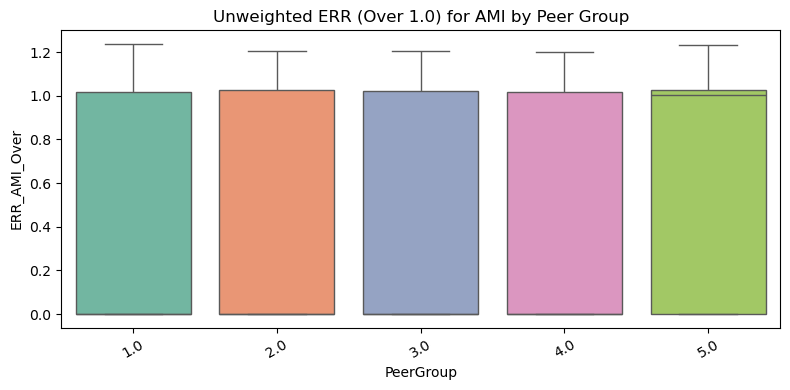

✅ Weighted ERR (WERR) summary by PeerGroup:


WERR_AMI_Over                           WERR_AMI_Under         \
                   mean    std median  min    max           mean    std   
PeerGroup                                                                 
1.0               0.009  0.014  0.000  0.0  0.075          0.012  0.019   
2.0               0.010  0.014  0.000  0.0  0.068          0.011  0.014   
3.0               0.008  0.013  0.000  0.0  0.077          0.011  0.014   
4.0               0.008  0.012  0.000  0.0  0.062          0.008  0.012   
5.0               0.009  0.012  0.004  0.0  0.082          0.004  0.008   

                              ... WERR_THA_TKA_Over                            \
          median  min    max  ...              mean    std median  min    max   
PeerGroup                     ...                                               
1.0        0.003  0.0  0.135  ...             0.043  0.100    0.0  0.0  0.838   
2.0        0.003  0.0  0.082  ...             0.024  0.040    0.0  0.0  0.512   
3.0        0.004  0.0  0.079  ...             0.021  0.033    0.0  0.0  0.368   
4.0        0.002  0.0  0.067  ...             0.019  0.029    0.0  0.0  0.202   
5.0        0.000  0.0  0.052  ...             0.011  0.020    0.0  0.0  0.195   

          WERR_THA_TKA_Under                            
                        mean    std median  min    max  
PeerGroup                                               
1.0                    0.080  0.132  0.027  0.0  0.669  
2.0                    0.029  0.046  0.009  0.0  0.574  
3.0                    0.025  0.038  0.006  0.0  0.357  
4.0                    0.019  0.034  0.001  0.0  0.420  
5.0                    0.012  0.021  0.001  0.0  0.158  

[5 rows x 60 columns]

/tmp/ipykernel_419/2136102269.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


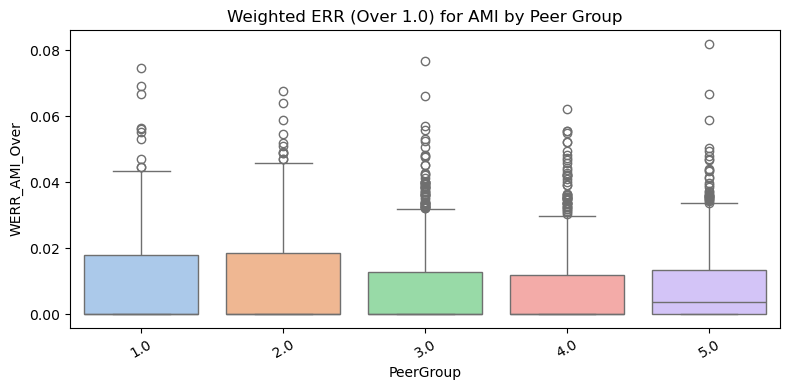

✅ DRG Weight summary by Condition:


,count,mean,std,min,median,max
Condition,,,,,,
AMI,2927,0.018,0.014,0.0,0.015,0.138
CABG,1154,0.020,0.018,0.0,0.018,0.308
COPD,3039,0.028,0.020,0.0,0.024,0.245
HF,3024,0.034,0.015,0.0,0.033,0.169
Pneumonia,3052,0.060,0.038,0.0,0.052,0.583
THA/TKA,2808,0.060,0.088,0.0,0.037,0.710


/tmp/ipykernel_419/2136102269.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


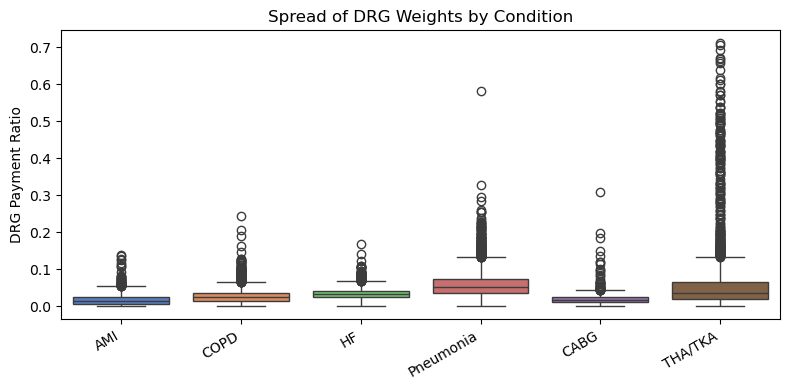

In [14]:
# ==============================================================
# STEP 7.  SUMMARY STATISTICS (WEIGHTED vs UNWEIGHTED)
# --------------------------------------------------------------
# Goal:
#   • Summarize and visualize ERR_Over / ERR_Under (unweighted)
#   • Summarize and visualize WERR_Over / WERR_Under (weighted)
# ==============================================================

import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 7A. UNWEIGHTED ERR SUMMARIES
# -----------------------------
err_cols_split = [c for c in df_eda.columns if c.startswith("ERR_") and not c.startswith("WERR_")]

err_peer_summary = (
    df_eda.groupby("PeerGroup")[err_cols_split]
    .agg(["mean", "std", "median", "min", "max"])
    .round(3)
)

print("✅ Unweighted ERR summary by PeerGroup:")
display(err_peer_summary)

# Example visualization for unweighted ERR (AMI)
plt.figure(figsize=(8,4))
sns.boxplot(
    data=df_eda,
    x="PeerGroup",
    y="ERR_AMI_Over",
    palette="Set2"
)
plt.title("Unweighted ERR (Over 1.0) for AMI by Peer Group")
plt.ylabel("ERR_AMI_Over")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# -----------------------------
# 7B. WEIGHTED ERR SUMMARIES
# -----------------------------
werr_cols_split = [c for c in df_eda.columns if c.startswith("WERR_")]

werr_peer_summary = (
    df_eda.groupby("PeerGroup")[werr_cols_split]
    .agg(["mean", "std", "median", "min", "max"])
    .round(3)
)

print("✅ Weighted ERR (WERR) summary by PeerGroup:")
display(werr_peer_summary)

# Example visualization for weighted ERR (AMI)
plt.figure(figsize=(8,4))
sns.boxplot(
    data=df_eda,
    x="PeerGroup",
    y="WERR_AMI_Over",
    palette="pastel"
)
plt.title("Weighted ERR (Over 1.0) for AMI by Peer Group")
plt.ylabel("WERR_AMI_Over")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# -----------------------------
# 7C. CONDITION-LEVEL SUMMARIES
# -----------------------------
# Melt DRG weights for condition-level view
drg_cols = [c for c in df_eda.columns if c.startswith("DRG payment ratio for")]
df_long_drg = df_eda.melt(
    id_vars=["Hospital CCN", "PeerGroup"],
    value_vars=drg_cols,
    var_name="Condition",
    value_name="DRG_Weight"
)
df_long_drg["Condition"] = df_long_drg["Condition"].str.replace("DRG payment ratio for ", "")

cond_summary = (
    df_long_drg.groupby("Condition")["DRG_Weight"]
    .agg(["count", "mean", "std", "min", "median", "max"])
    .round(3)
)

print("✅ DRG Weight summary by Condition:")
display(cond_summary)

# Visualization: DRG weights by condition
plt.figure(figsize=(8,4))
sns.boxplot(
    data=df_long_drg,
    x="Condition",
    y="DRG_Weight",
    palette="muted"
)
plt.title("Spread of DRG Weights by Condition")
plt.ylabel("DRG Payment Ratio")
plt.xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


/tmp/ipykernel_419/2624085246.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


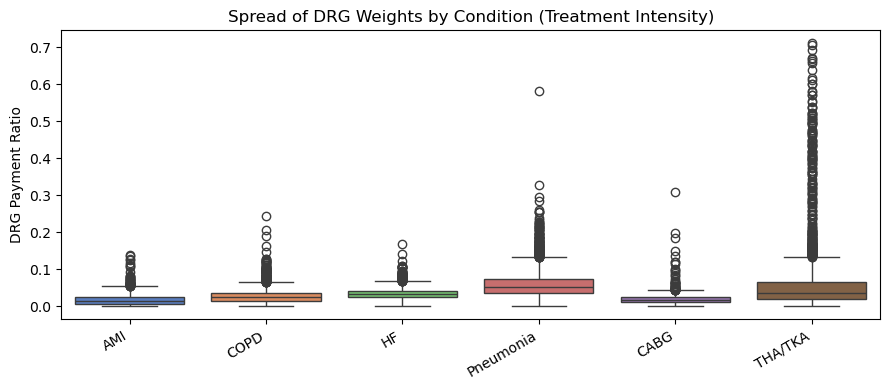

/tmp/ipykernel_419/2624085246.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


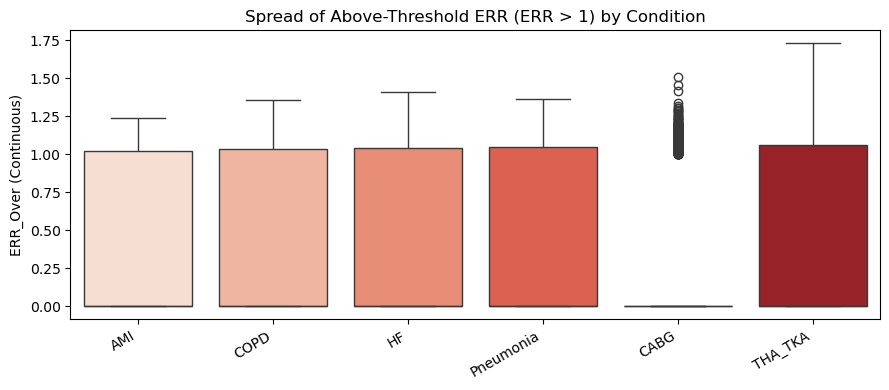

/tmp/ipykernel_419/2624085246.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


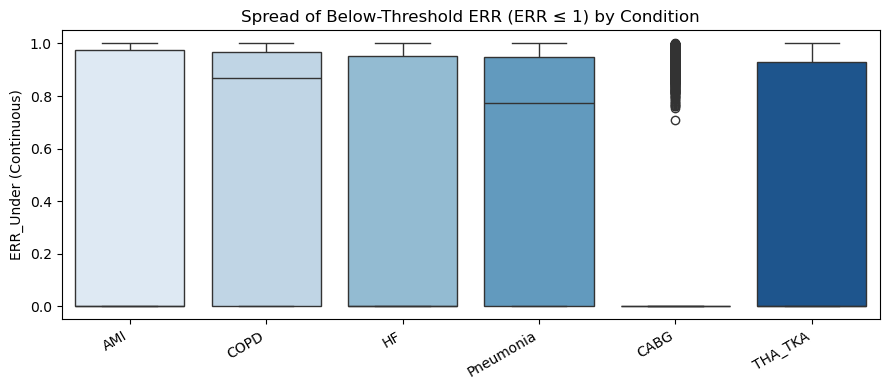

In [15]:
# ==============================================================
# STEP 7D.  VISUALIZE BY DISEASE AREA (DRG & ERR SPREAD)
# --------------------------------------------------------------
# Goal:
#   • Compare DRG payment ratios across conditions
#   • Compare ERR_Over and ERR_Under across the six HRRP diseases
# ==============================================================

import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 7D-1: DRG Weight spread by condition ---
drg_cols = [c for c in df_eda.columns if c.startswith("DRG payment ratio for")]
df_long_drg = df_eda.melt(
    id_vars=["Hospital CCN", "PeerGroup"],
    value_vars=drg_cols,
    var_name="Condition",
    value_name="DRG_Weight"
)
df_long_drg["Condition"] = df_long_drg["Condition"].str.replace("DRG payment ratio for ", "")

plt.figure(figsize=(9,4))
sns.boxplot(
    data=df_long_drg,
    x="Condition",
    y="DRG_Weight",
    palette="muted"
)
plt.title("Spread of DRG Weights by Condition (Treatment Intensity)")
plt.ylabel("DRG Payment Ratio")
plt.xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# --- Step 7D-2: ERR_Over and ERR_Under by disease ---
err_over_cols = [c for c in df_eda.columns if c.endswith("_Over") and c.startswith("ERR_")]
err_under_cols = [c for c in df_eda.columns if c.endswith("_Under") and c.startswith("ERR_")]

# Melt into long form for plotting
df_long_over = df_eda.melt(
    id_vars=["Hospital CCN", "PeerGroup"],
    value_vars=err_over_cols,
    var_name="Condition",
    value_name="ERR_Over"
)
df_long_under = df_eda.melt(
    id_vars=["Hospital CCN", "PeerGroup"],
    value_vars=err_under_cols,
    var_name="Condition",
    value_name="ERR_Under"
)

# Clean the condition names
df_long_over["Condition"] = df_long_over["Condition"].str.replace("ERR_", "").str.replace("_Over", "")
df_long_under["Condition"] = df_long_under["Condition"].str.replace("ERR_", "").str.replace("_Under", "")

# --- Visualization 1: ERR_Over by condition ---
plt.figure(figsize=(9,4))
sns.boxplot(
    data=df_long_over,
    x="Condition",
    y="ERR_Over",
    palette="Reds"
)
plt.title("Spread of Above-Threshold ERR (ERR > 1) by Condition")
plt.ylabel("ERR_Over (Continuous)")
plt.xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- Visualization 2: ERR_Under by condition ---
plt.figure(figsize=(9,4))
sns.boxplot(
    data=df_long_under,
    x="Condition",
    y="ERR_Under",
    palette="Blues"
)
plt.title("Spread of Below-Threshold ERR (ERR ≤ 1) by Condition")
plt.ylabel("ERR_Under (Continuous)")
plt.xlabel("")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


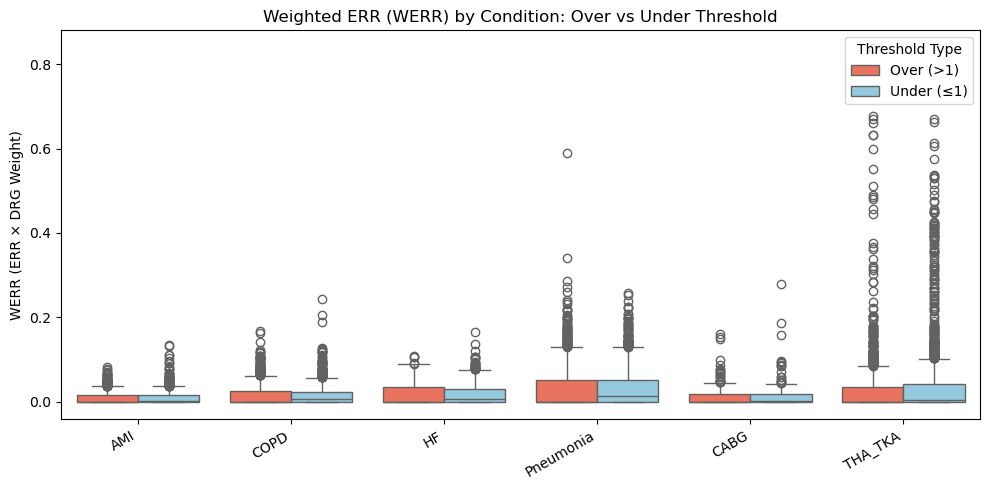

In [19]:
# ==============================================================
# STEP 7E (Fixed).  VISUALIZE WEIGHTED ERR (WERR) BY CONDITION
# --------------------------------------------------------------
# Goal:
#   • Combine WERR_Over and WERR_Under across conditions
#   • Show penalty-side (Over >1) vs. non-penalty-side (Under ≤1)
# ==============================================================

import seaborn as sns
import matplotlib.pyplot as plt

# Identify WERR columns
werr_over_cols = [c for c in df_eda.columns if c.startswith("WERR_") and c.endswith("_Over")]
werr_under_cols = [c for c in df_eda.columns if c.startswith("WERR_") and c.endswith("_Under")]

# --- Step 7E-1: Melt into long format ---
df_long_werr_over = df_eda.melt(
    id_vars=["Hospital CCN", "PeerGroup"],
    value_vars=werr_over_cols,
    var_name="Condition",
    value_name="WERR_Over"
)
df_long_werr_over["Condition"] = (
    df_long_werr_over["Condition"]
    .str.replace("WERR_", "")
    .str.replace("_Over", "")
)

df_long_werr_under = df_eda.melt(
    id_vars=["Hospital CCN", "PeerGroup"],
    value_vars=werr_under_cols,
    var_name="Condition",
    value_name="WERR_Under"
)
df_long_werr_under["Condition"] = (
    df_long_werr_under["Condition"]
    .str.replace("WERR_", "")
    .str.replace("_Under", "")
)

# --- Step 7E-2: Combine both into one long DataFrame ---
df_werr_long = pd.concat(
    [
        df_long_werr_over.assign(Type="Over (>1)"),
        df_long_werr_under.assign(Type="Under (≤1)")
    ],
    ignore_index=True  # avoids duplicate index alignment issues
)

# Create unified numeric column for plotting
df_werr_long["WERR_Value"] = df_werr_long["WERR_Over"].fillna(df_werr_long["WERR_Under"])

# --- Step 7E-3: Plot combined view ---
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_werr_long,
    x="Condition",
    y="WERR_Value",
    hue="Type",
    palette={"Over (>1)": "tomato", "Under (≤1)": "skyblue"}
)
plt.title("Weighted ERR (WERR) by Condition: Over vs Under Threshold")
plt.ylabel("WERR (ERR × DRG Weight)")
plt.xlabel("")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Threshold Type", loc="upper right")
plt.tight_layout()
plt.show()


In [21]:
# ==============================================================
# REGRESSION 3: INTERACTION (ERR × DRG WEIGHT) FOR AMI
# --------------------------------------------------------------
# Purpose:
#   Test whether the financial intensity (DRG weight)
#   amplifies the penalty impact of high ERR values.
# ==============================================================

import statsmodels.formula.api as smf

# --- Step 1. Rename DRG column so Patsy can parse it ---
df_eda = df_eda.rename(columns={
    "DRG payment ratio for AMI": "DRG_AMI"
})

# --- Step 2. Run the interaction regression ---
model3 = smf.ols(
    formula="A_h ~ ERR_AMI_Over * DRG_AMI + DualShare + C(PeerGroup)",
    data=df_eda
).fit()

# --- Step 3. Display summary ---
print(model3.summary())



                            OLS Regression Results                            
Dep. Variable:                    A_h   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     33.89
Date:                Mon, 03 Nov 2025   Prob (F-statistic):           1.66e-51
Time:                        15:22:49   Log-Likelihood:                 10670.
No. Observations:                2927   AIC:                        -2.132e+04
Df Residuals:                    2918   BIC:                        -2.127e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9939 